Program to find labels of a single image with saved model

Predicted Vehicle Type: CONVERTIBLE
Predicted Vehicle Type: 1
Predicted Vehicle Color: red
Classification took: 0.016s


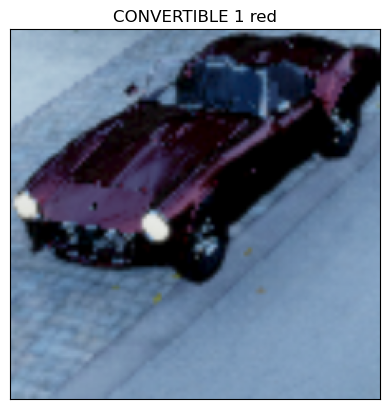

In [4]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import numpy as np
import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cpu training is slow, use GPU if available
weights = models.ResNet50_Weights.DEFAULT # grab resnet weights as base
model = models.resnet50(weights=weights)
num_ftrs = model.fc.in_features # get inputs from final layer
current_dir = os.getcwd()

model.fc = nn.Sequential( 
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(), 
    nn.Dropout(0.4), 
    nn.Linear(1024, 768),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 23),
)
_ = model.to(device) # move to GPU
model.load_state_dict(torch.load(os.path.join(current_dir, 'best_model6.pth')))
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

with open(os.path.join(current_dir, 'vt_encoder.pkl'), 'rb') as f:
    vt_encoder = pickle.load(f)

with open(os.path.join(current_dir, 'vst_encoder.pkl'), 'rb') as f:
    vst_encoder = pickle.load(f)

with open(os.path.join(current_dir, 'vc_encoder.pkl'), 'rb') as f:
    vc_encoder = pickle.load(f)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to preprocess the image and make predictions
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_tensor)
        
        vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)].argmax(dim=1)
        vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)].argmax(dim=1)
        vehicle_color_preds = outputs[:, len(vt_encoder.classes_) + len(vst_encoder.classes_):].argmax(dim=1)

        vehicle_type = vt_encoder.inverse_transform([vehicle_type_preds.item()])[0]
        vehicle_stype = vst_encoder.inverse_transform([vehicle_stype_preds.item()])[0]
        vehicle_color = vc_encoder.inverse_transform([vehicle_color_preds.item()])[0]
    return vehicle_type, vehicle_stype, vehicle_color

# Test the function with an example image
stime = time.time()
image_path = os.path.join(current_dir, '1.png')
vehicle_type, vehicle_stype, vehicle_color = classify_image(image_path)
etime = time.time()
ttime = etime - stime
print(f'Predicted Vehicle Type: {vehicle_type}')
print(f'Predicted Vehicle Type: {vehicle_stype}')
print(f'Predicted Vehicle Color: {vehicle_color}')
print(f'Classification took: {ttime:.3f}s')


# Display the image with the predictions
def imshow(img, title):
    # Denormalize the image
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

image = Image.open(image_path).convert("RGB")
input_tensor = transform(image)
imshow(input_tensor, f'{vehicle_type} {vehicle_stype} {vehicle_color}')